In [292]:
import simple_df_tools as dft
import feature_calculations as fc
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import random
%matplotlib inline
from sklearn.utils import shuffle
import matplotlib
import seaborn
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import itertools
from sklearn.externals import joblib

# Define the features to use

In [92]:
feature_dict = {'blobs_1':fc.calc_feature_1,
                'blobs_2': fc.calc_feature_2,
                'color_compactness':fc.color_compactness,
                'avg_blue':fc.compute_avg_blue,
                'avg_green':fc.compute_avg_green,
                'avg_red':fc.compute_avg_red,
                'tissue_discontinuity':fc.sift0_per_area
                }

# Check for existing df, or start from scratch

In [93]:
my_df = pd.DataFrame()
if os.path.exists('../data/camelyon_features.pkl'):
    my_df = pd.read_pickle('../data/camelyon_features.pkl')
else:
    my_df = pd.read_pickle('../data/my_simple_empty_df.pkl')
    for i in ['../data/slide_data/camelyon_metastatic/', '../data/slide_data/camelyon_normal/']:
        if not os.path.isdir(i): print "WARNING::Directory '", i, "' does not exist! Skipping..."; continue
        my_df = dft.add_slide(i, feature_dict, my_df)
    my_df.to_pickle('../data/camelyon_features.pkl')

# clean up frames that are majority white
my_df = my_df.loc[my_df.blobs_1 >-1]

# Log-transform for features peaked near zero

In [94]:
def log_transform(dataframe, feature):
    if not feature in dataframe.columns:
        print "WARNING::Feature not in dataframe, no transformation."
        return dataframe
    feature_min = np.min(dataframe.loc[dataframe[feature] > 0][feature])
    dataframe[feature] = np.log(dataframe[feature] + 0.1*feature_min)
    return dataframe
my_df = log_transform(my_df, 'color_compactness')
my_df = log_transform(my_df, 'tissue_discontinuity')

# Get matrix of features and train/test split before plotting

In [95]:
# which features to use
columns = ['blobs_2', 'color_compactness', 'tissue_discontinuity','avg_red','avg_green','avg_blue']

In [96]:
dfX = my_df.as_matrix(columns=columns)
dfY = (my_df.as_matrix(columns=['classification']) == 'metastatic')
dfID = (my_df.as_matrix(columns=['file_id']))

In [97]:
# set random seed
random.seed(1)
# ~ 60% of data for training
randList = [random.random()<0.6 for x in range(len(dfX))]

In [98]:
# train and test
trainX = np.array([dfX[x,:] for x in range(len(dfX)) if randList[x]])
notTrainX = np.array([dfX[x,:] for x in range(len(dfX)) if not randList[x]])
trainY = np.array([dfY[x,:] for x in range(len(dfX)) if randList[x]])
notTrainY = np.array([dfY[x,:] for x in range(len(dfX)) if not randList[x]])
trainID = np.array([dfID[x,:] for x in range(len(dfX)) if randList[x]])
notTrainID = np.array([dfID[x,:] for x in range(len(dfX)) if not randList[x]])

In [99]:
# cv and test
cvX = np.array([notTrainX[x] for x in range(len(notTrainX)) if x%2==0])
cvY = np.array([notTrainY[x] for x in range(len(notTrainX)) if x%2==0])
testX = np.array([notTrainX[x] for x in range(len(notTrainX)) if x%2==1])
testY = np.array([notTrainY[x] for x in range(len(notTrainX)) if x%2==1])
cvFileID = np.array([notTrainID[x] for x in range(len(notTrainX)) if x%2==0])
testFileID = np.array([notTrainID[x] for x in range(len(notTrainX)) if x%2==1])

In [100]:
# shuffle the training data (for evaluating learning curves)

In [166]:
shufX, shufY, shufID = shuffle(trainX, trainY, trainID, random_state=1)

In [167]:
shufY = shufY.reshape(-1,)

# Look at the (training) data!

In [168]:
# plotting function
def plot_feature(dataX, dataY, nBins, title, xlabel, ylabel):
    histogram = plt.figure()
    bins = np.linspace(np.min(dataX), np.max(dataX), nBins)
    plt.hist([dataX[x] for x in range(len(dataX)) if not dataY[x]], bins, weights=np.ones(len(dataY)-sum(dataY))/(len(dataY)-sum(dataY)), alpha=0.5, label='normal')
    plt.hist([dataX[x] for x in range(len(dataX)) if dataY[x]], bins, weights=np.ones(sum(dataY))/(sum(dataY)), alpha=0.5, label='metastatic')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(loc='best')
    return histogram

In [169]:
# global font size (& others?)
matplotlib.rcParams.update({'font.size': 14})
columns

['blobs_2',
 'color_compactness',
 'tissue_discontinuity',
 'avg_red',
 'avg_green',
 'avg_blue']

In [170]:
# dictionary for labels :(
labels = {'blobs_2':{'title': 'Nuclei Density', 'xlabel': 'Blobs / Active Area', 'ylabel':'arbitrary units'},
         'color_compactness':{'title':'Color Compactness', 'xlabel':'log[Color Compactness / Active Area]', 'ylabel':'arbitrary units'},
         'tissue_discontinuity':{'title':'Tissue Discontinuity', 'xlabel':'log[No. Edges / Active Area]', 'ylabel':'arbitrary units'},
         'avg_red':{'title':'Average Pixel Red', 'xlabel':'<Red>', 'ylabel':'arbitrary units'},
         'avg_green':{'title':'Average Pixel Green', 'xlabel':'<Green>', 'ylabel':'arbitrary units'},
         'avg_blue':{'title':'Average Pixel Blue', 'xlabel':'<Blue>', 'ylabel':'arbitrary units'}}

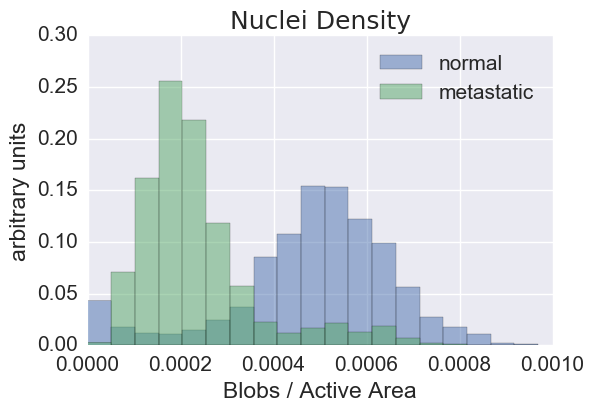

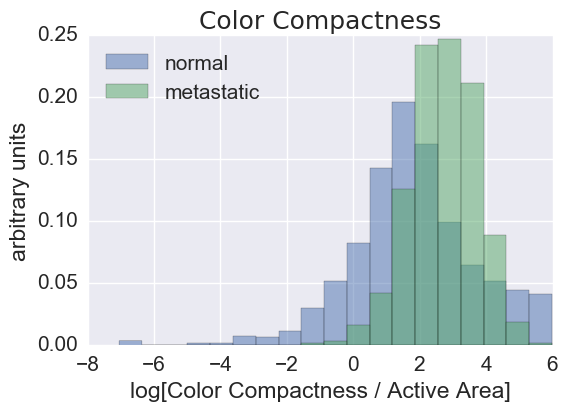

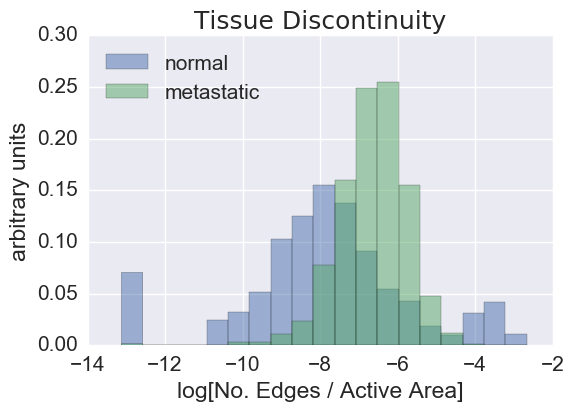

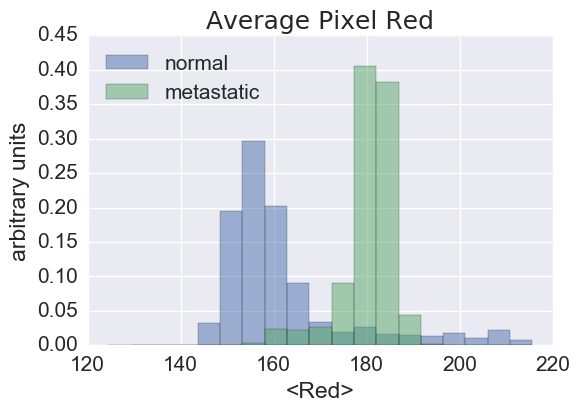

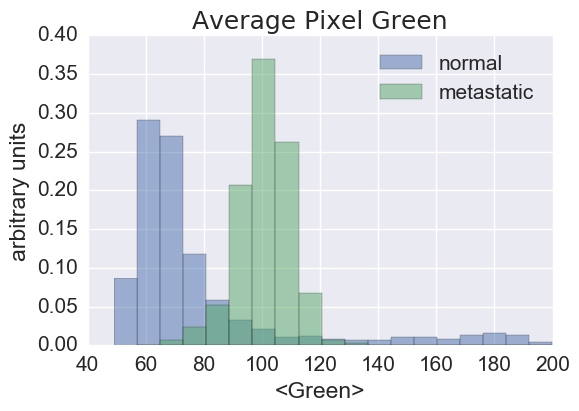

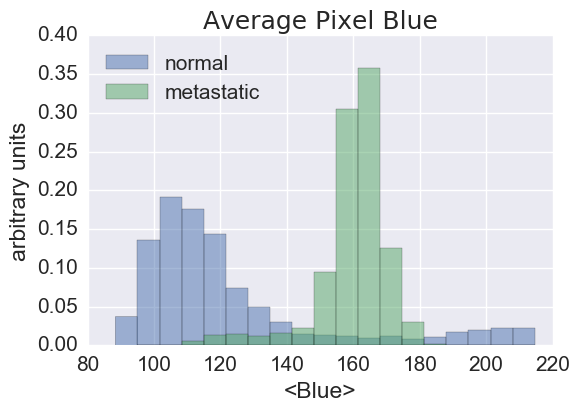

In [172]:
for i, feature in enumerate(columns):
    plot_feature(shufX[:,i], shufY, 20, labels[feature]['title'], 
                 labels[feature]['xlabel'], labels[feature]['ylabel'])

# Correlations among features?

In [199]:
corr = np.corrcoef(np.array(shufX.T))

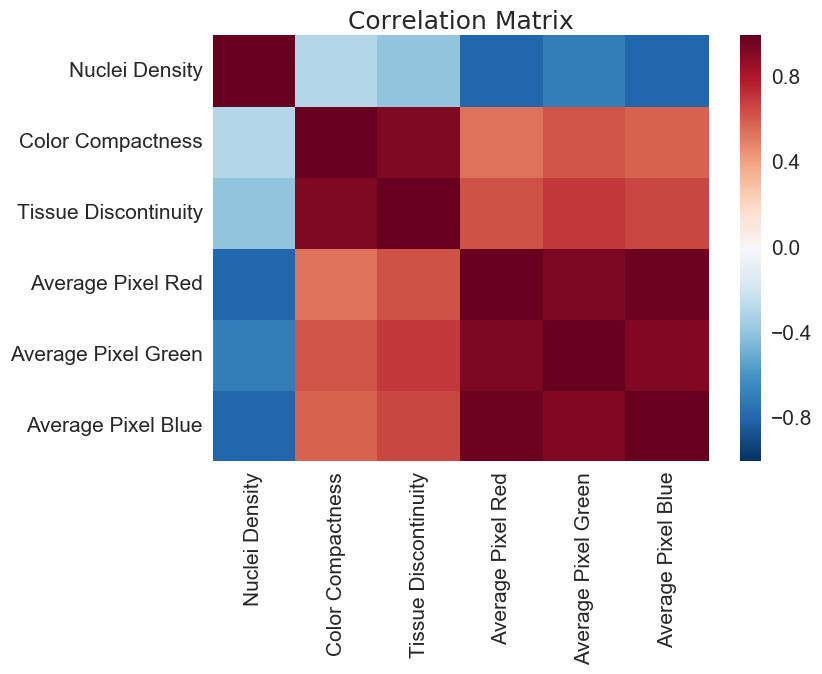

In [174]:
# note: corr is the matrix!
column_names = [labels[x]['title'] for x in columns]
seaborn.set(font_scale=1.5)
map = seaborn.heatmap(corr, xticklabels=column_names, yticklabels=column_names,)
map.set_xticklabels(column_names,rotation=90)
map.set_title("Correlation Matrix")

# Let's start modeling! 
# First -- logistic regression

In [181]:
scaler = preprocessing.StandardScaler().fit(shufX)

In [197]:
# iterate over regularization parameters
scoreDict = {}
for c in [0.0001, 0.0003,0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 1000, 10000]:
    logReg = LogisticRegression(C=c)
    logReg = logReg.fit(scaler.transform(shufX), shufY)
    score = logReg.score(scaler.transform(cvX), cvY)
    scoreDict[c] = score
max(scoreDict.items(), key=lambda x: x[1])

(30, 0.94641509433962268)

In [215]:
# train a model with the optimal parameter(s)
logReg = LogisticRegression(C=30)
logReg = logReg.fit(scaler.transform(shufX), shufY)
score = logReg.score(scaler.transform(cvX), cvY)
score

0.94641509433962268

## Learning curves

In [202]:
trainScore = {}
cvScore = {}
for n in range(2,len(shufX)):
    thisX = shufX[:n,:]
    thisY = shufY[:n].reshape(-1,)
    thisScaler = preprocessing.StandardScaler().fit(thisX)
    thisLogReg = LogisticRegression(C=30)
    thisLogReg.fit(thisScaler.transform(thisX), thisY)
    trainScore[n] = thisLogReg.score(thisScaler.transform(thisX), thisY)
    cvScore[n] = thisLogReg.score(thisScaler.transform(cvX), cvY)

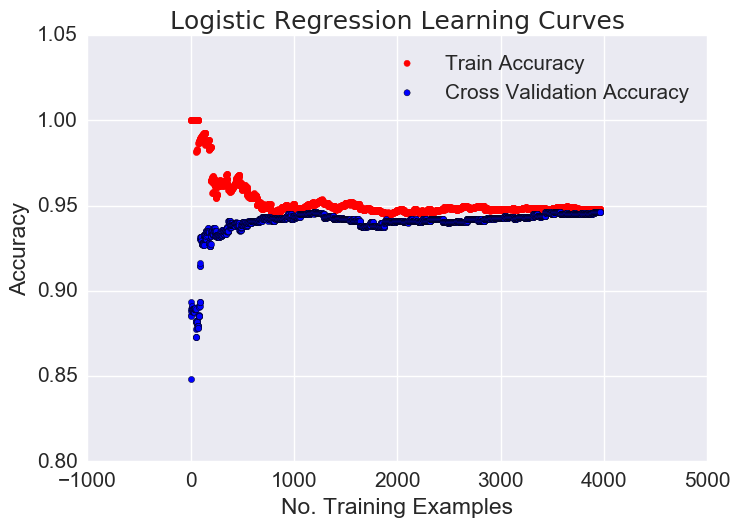

In [213]:
plt.scatter(trainScore.keys(), trainScore.values(), color='red', label='Train Accuracy')
plt.scatter(cvScore.keys(), cvScore.values(), label='Cross Validation Accuracy')
plt.xlabel('No. Training Examples')
plt.ylabel('Accuracy')
plt.title('Logistic Regression Learning Curves')
plt.legend()

In [233]:
# precision / recall
tp = sum([logReg.predict(scaler.transform(cvX))[x] == cvY[x][0] for x in range(len(cvY)) if cvY[x][0]])
tn = sum([logReg.predict(scaler.transform(cvX))[x] == cvY[x][0] for x in range(len(cvY)) if not cvY[x][0]])
fp = sum([logReg.predict(scaler.transform(cvX))[x] != cvY[x][0] for x in range(len(cvY)) if cvY[x][0]])
fn = sum([logReg.predict(scaler.transform(cvX))[x] != cvY[x][0] for x in range(len(cvY)) if not cvY[x][0]])
#sum([model.predict(scaler.transform(cvX))[x] != cvY[x][0] for x in range(len(cvY)) if cvY[x][0]])
#sum([model.predict(scaler.transform(cvX))[x] != cvY[x][0] for x in range(len(cvY)) if not cvY[x][0]])
tp, tn, fp, fn, len(cvY)
precision = float(tp) / (tp+fp)
recall = float(tp) / (tp + fn)
f1 = 2.*float(precision*recall) / (precision + recall)
precision, recall, f1

(0.9406528189910979, 0.9533834586466166, 0.946975354742345)

## Feature importance

In [260]:
logReg.coef_

array([[ -0.47816485,   1.13120385,   2.60977346,  16.44152392,
        -12.58542743,  -3.47356511]])

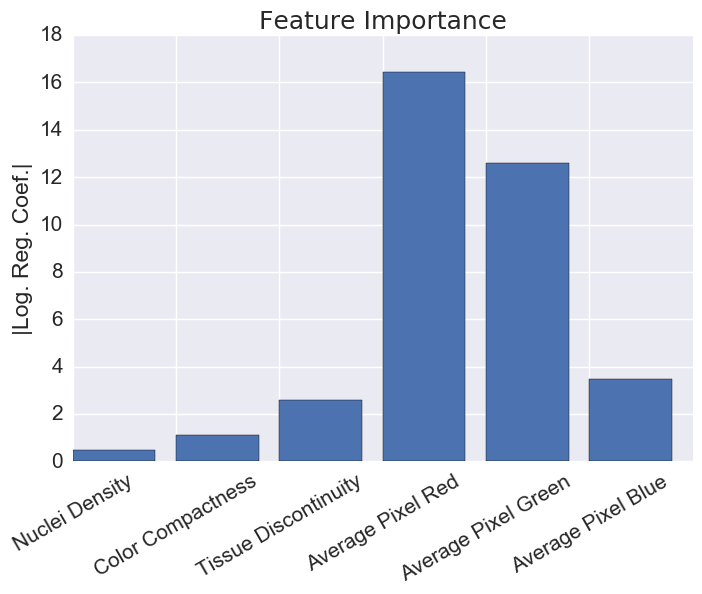

In [259]:
ypos = np.arange(len(columns))
plt.bar(ypos, abs(logReg.coef_)[0])
plt.xticks(ypos, column_names, rotation=30)
plt.title('Feature Importance')
plt.ylabel('|Log. Reg. Coef.|')

# Now let's switch to a nonlinear classifier:
## MLPClassifier

In [263]:
# try 1 hidden layer and iterate over size
params = [(x,) for x in range(2,12)]

In [266]:
mlpScoreDict = {}
for i in params:
    for a in [0.00001, 0.00003, 0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300]:
        mlp = MLPClassifier(solver='lbfgs', alpha=a, activation='relu', random_state=1, hidden_layer_sizes=i)
        mlp.fit(scaler.transform(shufX), shufY)
        mlpScoreDict[str(i[0])+'_'+str(a)] = mlp.score(scaler.transform(cvX), cvY)

In [268]:
max(mlpScoreDict.items(), key=lambda x: x[1])

('4_0.01', 0.97283018867924531)

In [281]:
# now add a second hidden layer
params2 = [x for x in range(2,12)]
params2 = [element for element in itertools.product([4],params2)]

In [277]:
for i in params2:
    mlp = MLPClassifier(solver='lbfgs', alpha=0.01, activation='relu', random_state=1, hidden_layer_sizes=i)
    mlp.fit(scaler.transform(shufX), shufY)
    mlpScoreDict[str(i[0])+'_'+str(i[1])+'_'+str(0.01)] = mlp.score(scaler.transform(cvX), cvY)

In [278]:
max(mlpScoreDict.items(), key=lambda x: x[1])

('4_0.01', 0.97283018867924531)

In [280]:
# One hidden layer is best!

## Learning curve for MLPClassifier

In [287]:
mlpTrainScore = {}
mlpCVScore = {}
for n in range(2,len(shufX),20):
    if (n-2)%1000 == 0: print "n=",n
    thisX = shufX[:n,:]
    thisY = shufY[:n].reshape(-1,)
    thisScaler = preprocessing.StandardScaler().fit(thisX)
    thisMLP = MLPClassifier(solver='lbfgs', alpha=0.01, activation='relu', random_state=1, hidden_layer_sizes=(4,))
    thisMLP.fit(thisScaler.transform(thisX), thisY)
    mlpTrainScore[n] = thisMLP.score(thisScaler.transform(thisX), thisY)
    mlpCVScore[n] = thisMLP.score(thisScaler.transform(cvX), cvY)

n= 2
n= 1002
n= 2002
n= 3002


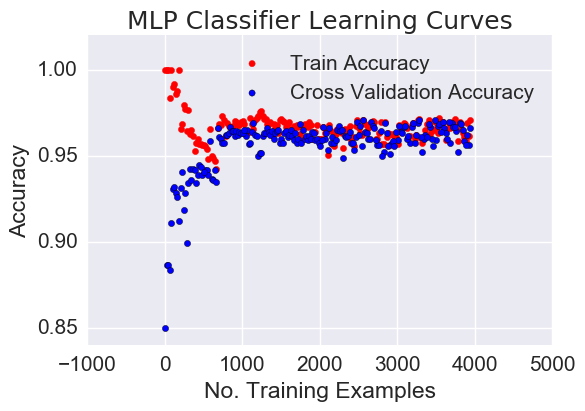

In [288]:
plt.scatter(mlpTrainScore.keys(), mlpTrainScore.values(), color='red', label='Train Accuracy')
plt.scatter(mlpCVScore.keys(), mlpCVScore.values(), label='Cross Validation Accuracy')
plt.xlabel('No. Training Examples')
plt.ylabel('Accuracy')
plt.title('MLP Classifier Learning Curves')
plt.legend()

In [289]:
mlp = MLPClassifier(solver='lbfgs', alpha=0.01, activation='relu', random_state=1, hidden_layer_sizes=(4,))
mlp.fit(scaler.transform(shufX), shufY)

MLPClassifier(activation='relu', alpha=0.01, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(4,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [291]:
# precision / recall
tp = sum([mlp.predict(scaler.transform(cvX))[x] == cvY[x][0] for x in range(len(cvY)) if cvY[x][0]])
tn = sum([mlp.predict(scaler.transform(cvX))[x] == cvY[x][0] for x in range(len(cvY)) if not cvY[x][0]])
fp = sum([mlp.predict(scaler.transform(cvX))[x] != cvY[x][0] for x in range(len(cvY)) if cvY[x][0]])
fn = sum([mlp.predict(scaler.transform(cvX))[x] != cvY[x][0] for x in range(len(cvY)) if not cvY[x][0]])
#sum([model.predict(scaler.transform(cvX))[x] != cvY[x][0] for x in range(len(cvY)) if cvY[x][0]])
#sum([model.predict(scaler.transform(cvX))[x] != cvY[x][0] for x in range(len(cvY)) if not cvY[x][0]])
tp, tn, fp, fn, len(cvY)
precision = float(tp) / (tp+fp)
recall = float(tp) / (tp + fn)
f1 = 2.*float(precision*recall) / (precision + recall)
precision, recall, f1

(0.9658753709198813, 0.9804216867469879, 0.9730941704035874)

# Write out model for later :)))

In [293]:
joblib.dump(scaler, 'week4_demo_scaler.pkl')

['week4_demo_scaler.pkl']

In [294]:
joblib.dump(mlp, 'week4_demo_mlp_classifier.pkl')

['week4_demo_mlp_classifier.pkl']